In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from metrics import *
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/application_train.csv").reset_index(drop=True)
df

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/application_train.csv'

In [3]:
def clean(data, stringThing = "", numThing = 0):
    for col in data.columns:
        if data[col].dtype == "object":
            data[col] = data[col].astype(str)
            data[col].fillna(stringThing, inplace=True)
        else:
            data[col].fillna(numThing, inplace=True)
    return data
df = clean(df)

In [4]:
df["TARGET"].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [5]:
df = df[df["CODE_GENDER"] != "XNA"]
df.shape

(307507, 122)

# Data Preparation and Feature Engineering

<Axes: xlabel='CODE_GENDER'>

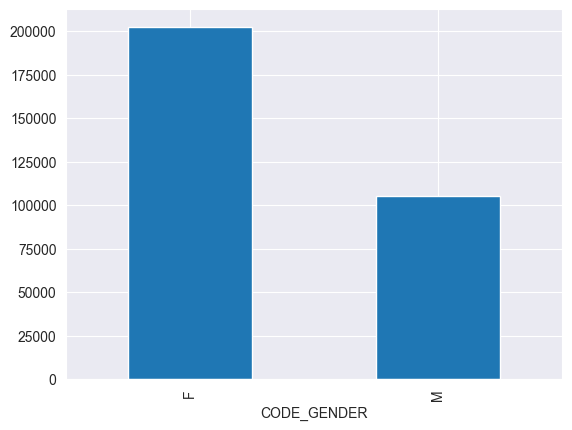

In [6]:
# make some plots
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df["CODE_GENDER"].value_counts().plot.bar()

Text(50.722222222222214, 0.5, 'Do they own a car?')

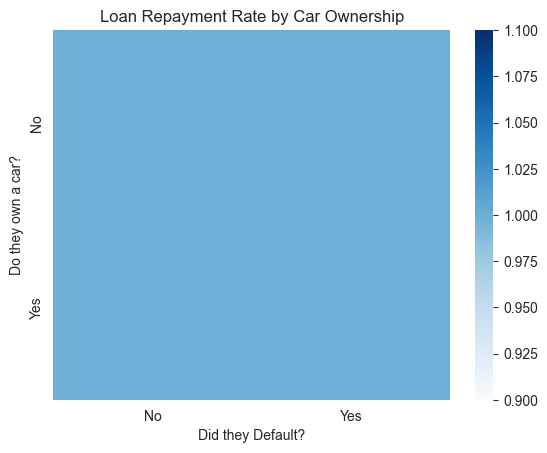

In [7]:
# make a heatmap of proportion of code_gender and target
copy = df[["FLAG_OWN_CAR", "TARGET"]].copy()
copy["TARGET"] = copy["TARGET"].apply(lambda target: "Yes" if target == 1 else "No")
copy["FLAG_OWN_CAR"] = copy['FLAG_OWN_CAR'].apply(lambda x: "Yes" if x == "Y" else "No")
valueCounts = copy.value_counts(normalize=True).unstack()
# make a cross tab table of the value counts
valueCounts = pd.crosstab(copy["FLAG_OWN_CAR"], copy["TARGET"], normalize=True).divide(valueCounts)
sns.heatmap(valueCounts, annot=False, cmap='Blues')
plt.title("Loan Repayment Rate by Car Ownership")
plt.xlabel("Did they Default?")
plt.ylabel("Do they own a car?")

In [8]:
# make a conditional probability table of the target and car ownership
copy = df[["FLAG_OWN_CAR", "TARGET"]].copy()
copy["TARGET"] = copy["TARGET"].apply(lambda target: "Yes" if target == 1 else "No")
copy["FLAG_OWN_CAR"] = copy['FLAG_OWN_CAR'].apply(lambda x: "Yes" if x == "Y" else "No")
valueCounts = pd.crosstab(copy["FLAG_OWN_CAR"], copy["TARGET"], normalize=True)
valueCounts.shape

(2, 2)

In [9]:
valueCounts

TARGET,No,Yes
FLAG_OWN_CAR,,
No,0.603801,0.056093
Yes,0.315469,0.024637


# Cross Validation Splits

In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp+fp) if (tp+fp) != 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp+fn) if (tp+fn) != 0 else 0

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p+r) if p+r != 0 else 0

def roc_auc(y_true, y_pred, plot=False):
    thresholds = np.linspace(0, 1, 100)
    tpr = []
    fpr = []
    for threshold in thresholds:
        classifications = np.where(y_pred >= threshold, 1, 0)
        tp = np.sum((classifications == 1) & (y_true == 1))
        fp = np.sum((classifications == 1) & (y_true == 0))
        tn = np.sum((classifications == 0) & (y_true == 0))
        fn = np.sum((classifications == 0) & (y_true == 1))
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    if plot:
        plt.plot(fpr, tpr)
    return abs(np.trapz(fpr, tpr))

In [ ]:
from LogisticRegressionManual import LogisticRegressionManual
def dummies(data):
    dummyCols = [col for col in data.columns if data[col].nunique() < data.shape[0]] # filter out id columns automatically
    return pd.get_dummies(data[dummyCols]).astype(int)

def splits(data, mode="random", v=5):
    data.reset_index(drop=True, inplace=True)
    data = dummies(data)
    X = data.drop("TARGET", axis=1)
    y = data["TARGET"]
    folds = []
    if mode == "random":
        for i in range(v):
            trainIndex = np.random.choice(X.index, size=int(len(X)*0.8), replace=False)
            testIndex = X.index.difference(trainIndex)
            X_train = X.iloc[trainIndex]
            X_test = X.iloc[testIndex]
            y_train = y.iloc[trainIndex]
            y_test = y.iloc[testIndex]
            folds.append((X_train, X_test, y_train, y_test))
    elif mode == "stratified":
        splitNum = 0.8
        for i in range(v):
            strat0 = df[df["TARGET"] == 0].sample(int(len(X)*splitNum), replace=False)
            strat1 = df[df["TARGET"] == 1].sample(int(len(X)*(1-splitNum)), replace=True)
            strat_sample = pd.concat([strat0, strat1]).sample(frac=1).reset_index(drop=True)
            testIndex = strat_sample.index[int(len(X)*splitNum):]
            trainIndex = strat_sample.index[:int(len(X)*splitNum)]
            X_train = X.iloc[trainIndex]
            X_test = X.iloc[testIndex]
            y_train = y.iloc[trainIndex]
            y_test = y.iloc[testIndex]
            folds.append((X_train, X_test, y_train, y_test))
    elif mode == "non-random":
        interval = len(X) // v
        for i in range(v):
            testIndex = np.arange(i * interval, (i+1) * interval)
            testIndex = testIndex[testIndex < len(X)]
            trainIndex = X.index.difference(testIndex)
            trainIndex = trainIndex[trainIndex < len(X)]
            X_train = X.iloc[trainIndex]
            X_test = X.iloc[testIndex]
            y_train = y.iloc[trainIndex]
            y_test = y.iloc[testIndex]
            folds.append((X_train, X_test, y_train, y_test))
    else:
        raise ValueError(f"Invalid mode: {mode}")
    return folds

def cv(data, mode="random", v=5, models=[LogisticRegressionManual(), SVC(), LinearDiscriminantAnalysis(solver="lsqr")]):
    folds = splits(data, mode, v)
    things = pd.DataFrame(columns=["model", "fold", "accuracy", "precision", "recall", "f1", "roc_auc"])
    for m in models:
        i = 1
        for X_train, X_test, y_train, y_test in folds:
            try:
                m.probability = True
            except:
                pass
            m.fit(X_train, y_train)
            predictions = m.predict(X_test)
            predictions = pd.Series(predictions, index=X_test.index)
            probabilities = m.predict_proba(X_test)
            probabilities = pd.Series(probabilities[:,1], index=X_test.index)
            stuff = {}
            stuff["accuracy"] = accuracy(y_test, predictions)
            stuff["precision"] = precision(y_test, predictions)
            stuff["recall"] = recall(y_test, predictions)
            stuff["f1"] = f1(y_test, predictions)
            stuff["roc_auc"] = roc_auc(y_test, probabilities)
            stuff["model"] = str(m)
            stuff["fold"] = i
            i += 1
            stuff = pd.DataFrame([stuff])
            things = pd.concat([things, stuff])
    return things

things = cv(df, mode="random")
things

In [47]:
stuff = splits(df.sample(n=500), mode="stratified", v=10)
X_train, X_test, y_train, y_test = stuff[0]
y_train.value_counts(normalize=True)

TARGET
0    0.937343
1    0.062657
Name: proportion, dtype: float64